# PythonFMU example

This is an example on how to use PythonFMU in order to export a Python script as a FMI 2.0 for CoSimulation compliant FMU.

## Installation

But first thing first, you will need the `pythonfmu` Python package. To install it, you can use the pip package manager:

```bash
python -m pip install pythonfmu
```

## The to-be-exported script

To export Python code as FMU, you will need to interface your code with the FMI facade provided through an abstract class `pythonfmu.Fmi2Slave`.

In the following example, you will interface a simple resistor code.

In [1]:
%%bash
more ./demoslave.py

::::::::::::::
./demoslave.py
::::::::::::::
from pythonfmu import Fmi2Causality, Fmi2Variability, Fmi2Slave, Boolean, Integer, Real, String

slave_class = "Resistor"  # REQUIRED - Name of the class extending Fmi2Slave


class Resistor(Fmi2Slave):

    author = "John Doe"
    description = "A simple description"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.positive_pin_v = 20.
        self.positive_pin_i = 0.001
        self.negative_pin_v = 10.
        self.negative_pin_i = 0.001
        self.delta_v = 10.
        self.i = 0.001
        self.R = 10000.
        
        self.register_variable(Real("R", causality=Fmi2Causality.parameter))

        self.register_variable(Real("positive_pin_v", causality=Fmi2Causality.input, variability=Fmi2Variability.tunable))
        self.register_variable(Real("positive_pin_i", causality=Fmi2Causality.output))
        self.register_variable(Real("negative_pin_v", causality=Fmi2Causality.input, variability=Fmi2Var

## Generate the FMU

The FMU is generate through the command line tool `pythonfmu-builder`.

In [2]:
!pythonfmu-builder -f ./demoslave.py --no-external-tool

The mandatory information to pass to the builder is the Python script file through the `-f` option. 

> By default the generated FMU states that a external tool (i.e. Python) is needed for its execution. But the usage of the FMU is demonstrated through `pyfmi` that does not support that feature. This is the reason the option `--no-external-tool` is provided.

The full list of available options is:

In [3]:
!pythonfmu-builder -h

usage: pythonfmu-builder [-h] -f SCRIPT_FILE [-d DEST]
                         [--doc DOCUMENTATION_FOLDER] [--no-external-tool]
                         [--no-variable-step] [--interpolate-inputs]
                         [--only-one-per-process] [--handle-state]
                         [--serialize-state] [--use-memory-management]
                         [Project files [Project files ...]]

Build a FMU from a Python script.

positional arguments:
  Project files         Additional project files required by the Python
                        script.

optional arguments:
  -h, --help            show this help message and exit
  -f SCRIPT_FILE, --file SCRIPT_FILE
                        Path to the Python script.
  -d DEST, --dest DEST  Where to save the FMU.
  --doc DOCUMENTATION_FOLDER
                        Documentation folder to include in the FMU.
  --no-external-tool    If given, needsExecutionTool=false
  --no-variable-step    If given, canHandleVariableCommunicationStepSize

## Use the FMU

You can now use the FMU. For example through the `pyfmi` Python package:

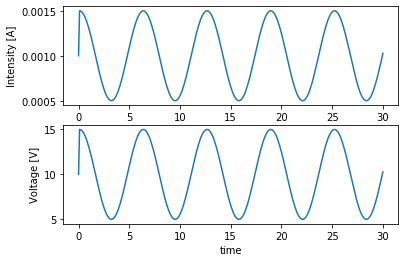

In [4]:
%matplotlib inline

from pyfmi import load_fmu

import matplotlib.pyplot as p
import numpy

model = load_fmu('Resistor.fmu')

inputs = ('positive_pin_v', lambda t: 20 + 5. * numpy.cos(t))

res = model.simulate(final_time=30, input=inputs, options={'ncp': 300})

fig = p.figure()
ax1 = p.subplot(2, 1, 1)
ax1.plot(res['time'], res['i'])
ax1.set_ylabel('Intensity [A]')
ax2 = p.subplot(2, 1, 2)
ax2.plot(res['time'], res['delta_v'])
ax2.set_xlabel('time')
ax2.set_ylabel('Voltage [V]')
p.show();

The code specifies a *parameter*, you could change it:

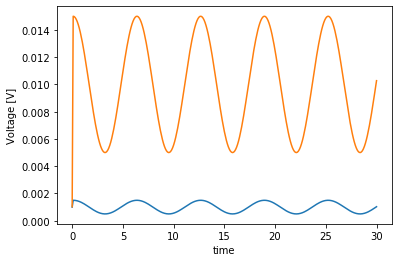

In [5]:
R_reference = model.get_model_variables()['R'].value_reference
model.set_real([R_reference, ], [1000., ])

res2 = model.simulate(final_time=30, input=inputs, options={'ncp': 300})

fig = p.figure()
p.plot(res['time'], res['i'], res2['time'], res2['i'])
p.xlabel('time')
p.ylabel('Voltage [V]')
p.show()